# Twitter Sentiment Analysis

This notebook aims to analyze Tweets made about the COVID-19 vaccine and determine whether the sentiment of the Tweets is negative, positive, or neutral.

## Libraries

In [2]:
import tweepy
import webbrowser
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import time

import config
pd.set_option('display.max_colwidth', None)

from tweepy import OAuthHandler
from tweepy import API

import os
from google.oauth2 import service_account
from google.cloud import translate_v2 as translate
from google.cloud import language

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk import FreqDist
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk import word_tokenize, TweetTokenizer, FreqDist
import string

import re
from textblob import TextBlob
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cassienutter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Gather data from Twitter API

In [ ]:
# Developer API keys
# API keys in config.py in .gitignore
callback_uri = 'oob'

In [ ]:
auth = OAuthHandler(config.consumer_key, config.consumer_secret, callback_uri)
auth.set_access_token(config.access_token, config.access_token_secret)

In [ ]:
api = API(auth, wait_on_rate_limit= True, wait_on_rate_limit_notify= True)

In [ ]:
# show my Twitter handle
me = api.me()
print(me.screen_name)

In [ ]:
# simple query to get the hang of it
query = '#vaccine covid -RT -@ -http'
for i, status in enumerate(tweepy.Cursor(api.search, q= query).items(15)):
    print (i, status.text)

# filter only English tweets    
# query = '#vaccine covid'
# for i, status in enumerate(tweepy.Cursor(api.search, q= query, lang= 'en').items(50)):
#     print (i, status.text)

In [ ]:
''' This cell was run to collect the initial 5000 tweets and save them to a csv file
is commented out to prevent it from being run again


# collect 5000 tweets 
number_of_tweets = 5000
tweets = []
language = []
time = []

# only collect full text, language, and time it was posted
# remove any retweets '-RT'
for i in tweepy.Cursor(api.search, q= 'vaccine covid -RT',  
                       tweet_mode = 'extended').items(number_of_tweets):
    tweets.append(i.full_text)
    language.append(i.lang)
    time.append(i.created_at)

# turn tweets / lists into dataframe
df = pd.DataFrame({'time': time, 'language': language, 'tweets': tweets})

# save df to csv
df.to_csv('data/tweets.csv', index= False)
'''

Collect more tweets after waiting to avoid collecting the same tweets.

In [ ]:
# create function to get more tweets and add to existing csv
def get_more_tweets(num_tweets):
    number_of_tweets = num_tweets
    tweets = []
    language = []
    time = []

    # only collect full text, language, and time it was posted
    # remove any retweets '-RT'
    for i in tweepy.Cursor(api.search, q= 'vaccine covid -RT',  
                           tweet_mode = 'extended').items(number_of_tweets):
        tweets.append(i.full_text)
        language.append(i.lang)
        time.append(i.created_at)
        
    # turn tweets / lists into dataframe
    df = pd.DataFrame({'time': time, 'language': language, 'tweets': tweets})
    
    # add to existing csv file
    df.to_csv('data/tweets.csv', mode= 'a', index= False, header= False)

In [ ]:
# get tweets and save to csv through function

# n_tweets = 20
# get_more_tweets(n_tweets)

### Search for Tweets from 30 Days Ago

In [ ]:
# function to turn results into DataFrame
def extract_text_as_df(text_list):
    columns = set()
    allowed_types = [str, int]
    tweets_data = []
    for status in text_list:
        status_dict = dict(vars(status))
        keys = status_dict.keys()
        single_tweet_data = {"author": status.author.screen_name}
        for k in keys:
            try:
                v_type = type(status_dict[k])
            except:
                v_type = None
            if v_type != None:
                if v_type in allowed_types:
                    single_tweet_data[k] = status_dict[k]
                    columns.add(k)
        tweets_data.append(single_tweet_data)


    header_cols = list(columns)
    header_cols.append('author')
    df = pd.DataFrame(tweets_data, columns=header_cols)
    return df

In [ ]:
query = 'vaccine covid -RT'
results_30 = api.search_30_day('datacollection', query, maxResults= 100)

In [ ]:
old_results_df = extract_text_as_df(results_30)

In [ ]:
old_results_df

## Data Cleaning & EDA

In [ ]:
df = pd.read_csv('data/tweets.csv')

In [ ]:
df.info()

### Check and Remove Duplicates

In [ ]:
# check for duplicated tweets
duped = df[df.duplicated(subset= 'tweets')]
duped.info()

In [ ]:
# remove duplicates
df.drop_duplicates(subset= 'tweets', keep= 'first', inplace= True)
df.reset_index(drop= True, inplace= True)

# make sure they are gone
df.tweets.duplicated().sum()

In [ ]:
df.head(15)

### Looking at Languages

In [ ]:
lang_df = df.sort_values('language')

In [ ]:
plt.figure(figsize= (12, 8))
lang_df.language.value_counts(normalize=True).plot(kind= 'barh')
plt.title('Proportion of Languages Collected')
plt.xlim(-.01, 1)
plt.show()

In [ ]:
lang_df.language.value_counts(normalize=True)

In [ ]:
# what are these languages? get table from url
URL = 'https://developer.twitter.com/en/docs/twitter-for-websites/supported-languages'
tables = pd.read_html(URL)
print("There are : ",len(tables)," tables")
print(tables[0])

lang_table = tables[0]

In [ ]:
# format table
header_row = 0
lang_table.columns = lang_table.iloc[header_row]
lang_table = lang_table.drop(header_row)
lang_table.reset_index(drop= True, inplace= True)

lang_table.replace('English (default)', 'English', inplace= True)
# lang_table

In [ ]:
# save as csv in data folder
lang_table.to_csv('data/languages.csv', index= False)

In [ ]:
# look at 'und' language 
df[df['language'] == 'und']

It appears that the 'und' or possibly 'undetermined' language are tweets that do not include text to help us with our sentiment analysis. We will remove those from our DataFrame.

In [ ]:
df = df[df['language'] != 'und']
# df.info()

Merge the data with the languages to see the whole name of languages

In [ ]:
# merge data with language names
df2 = df.merge(lang_table, how= 'inner', left_on= 'language', right_on= 'Language code')
df2.info()

In [ ]:
# drop extra columns and rename them and change dates to datetime and drop time
df2.drop(columns = ['language', 'Language code'], inplace= True)
df2.rename(columns={'Name': 'language'}, inplace= True)
df2['time'] = pd.to_datetime(df2['time']).dt.date
# df2

Let's see how many Tweets are in each language?

In [ ]:
sns.countplot(y= 'language', data= df2)

The majority of Tweets are in English. Let's see what the other languages are.

In [ ]:
# countplot that excludes English to see detail
plt.figure(figsize= (10, 8))
sns.countplot(y= 'language', data= df2, palette='plasma',
              order= df2.language.value_counts().iloc[1:].index)
plt.title('Count of Tweets, Excluding English', fontsize= 14)
plt.xlabel('# of Tweets')
plt.ylabel('Language')
plt.show()

After English, the top 3 languages for Tweets about the COVID-19 vaccine are in French, Spanish, and Japanese.

In [ ]:
df2.head(10)

#### Translate to English using Google Cloud Platform's API

**Most of this section has been commented out to prevent running on Google Cloud.**

In [ ]:
# send in credentials that are saved on local computer
credentials = service_account.Credentials.from_service_account_file('../GCP_service_account.json')
translate_client = translate.Client(credentials = credentials)

In [ ]:
# see all languages that Google can translate
print(translate_client.get_languages())

In [ ]:
# separate non-English tweets for faster translating
part_df = df2.loc[16100:]
# part_df.language.value_counts(normalize= True)

In [ ]:
# create dictionary to save original tweet and translated one
# commented out to prevent re-running on Google Cloud
'''
results = {}

# translate tweets into English
for i in part_df.tweets.loc[:]:
    result = translate_client.translate(i, target_language= 'en')
    results[i] = result['translatedText']
'''

In [ ]:
# replace with English translation
# df2.tweets.replace(results, inplace= True)

In [ ]:
# preview previously French Tweets
# df2[df2['language'] == 'French']

In [ ]:
# save to csv file
# df2.to_csv('data/tweets_translated.csv', index= False)

## Text Sentiment
---
Does the tweet have a positive, negative, or neutral tone?

### Feature Engineering for Text Data
--- 
stopword removal
frequency distributions
lemmatization
bigramsm n-grams, and mutal information score

In [ ]:
# load data from csv
df2 = pd.read_csv('data/tweets_translated.csv')

In [ ]:
# remove language column
sentiment_df = df2[['time', 'tweets']]
sentiment_df.head()

### Google Cloud Platform Natural Language Processing

In [ ]:
# input credentials from local file to access Google Cloud Platform
credentials = service_account.Credentials.from_service_account_file('../GCP_service_account.json')
nlp_client = language.Client(credentials = credentials)

In [ ]:
# function to collect sentiment from Google Cloud
scores = []
magnitudes = []

def getGoogleSentiments(txt):
    document = nlp_client.document_from_text(txt)
    
    sent_analysis = document.analyze_sentiment()
    sentiment = sent_analysis.sentiment
    
    # get score and magnitude and add to list
    score = sentiment.score
    scores.append(score)
    magnitude = sentiment.magnitude
    magnitudes.append(magnitude)
    # add delay to prevent hitting rate limit
    time.sleep(5)


In [ ]:
# get sentiment score and magnitude from function
# google_sent = sentiment_df.tweets.apply(getGoogleSentiments)

Unfortunately, I hit the free trial limit and was unable to utilize the service. There were 5546 scores and magnitudes that were added to a partial DataFrame.

_Google Cloud's Natural Language sentiment analysis markers:_

**Score** of the sentiment ranges between -1.0 (negative) and 1.0 (positive) and corresponds to the overall emotional leaning of the text.

**Magnitude** indicates the overall strength of emotion (both positive and negative) within the given text, between 0.0 and +inf. Unlike score, magnitude is not normalized; each expression of emotion within the text (both positive and negative) contributes to the text's magnitude (so longer text blocks may have greater magnitudes).

In [ ]:
''' This cell has been commented out, was created when Google Cloud code ran -  
saved list items to DataFrame and saved to csv

sentiment_part = sentiment_df[:5546]
sentiment_partial = sentiment_part.copy()

# add lists to DataFrame as new columns
sentiment_partial['Google Score'] = scores
sentiment_partial['Google Magnitude'] = magnitudes

# function to determine if Tweet was positive, negative, or neutral
def getTextAnalysis(p):
    if p < 0:
        return 'Negative'
    elif p == 0:
        return 'Neutral'
    else:
        return 'Positive'

sentiment_partial['Google Sentiment'] = sentiment_partial['Google Score'].apply(getTextAnalysis)

# save to csv file
sentiment_partial.to_csv('data/tweets_google_sentiment.csv', index= False)
'''

In [3]:
# load csv file to plot
google_partial = pd.read_csv('data/tweets_google_sentiment.csv')

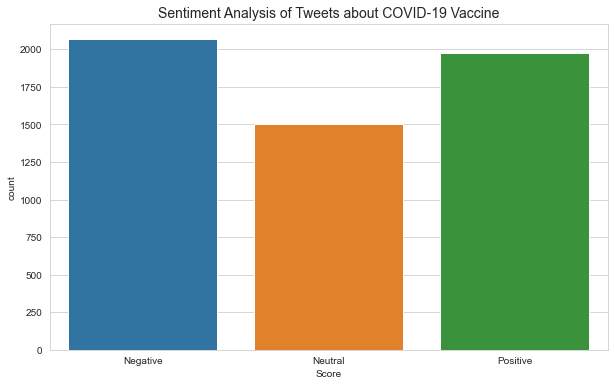

In [16]:
# plot as bar graph
plt.figure(figsize= (10, 6))
sns.countplot(data= google_partial, x = 'Google Sentiment')
plt.title('Sentiment Analysis of Tweets about COVID-19 Vaccine', fontsize = 14)
plt.xlabel('Score')
plt.show()

The classifications are fairly balanced.

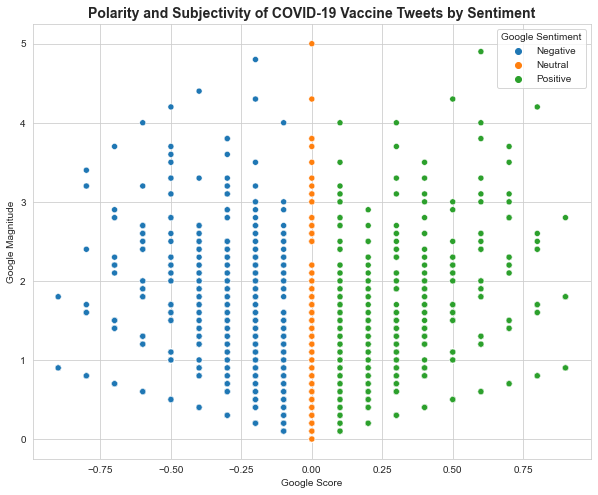

In [17]:
# plot polarity and subjectivity and sentiment of the Tweet
plt.figure(figsize= (10,8))
sns.scatterplot(x= 'Google Score', y= 'Google Magnitude', data= google_partial, hue= 'Google Sentiment')
plt.title('Polarity and Subjectivity of COVID-19 Vaccine Tweets by Sentiment', 
          fontsize = 14, fontweight= 'bold')
plt.show()

The symmetry of scores and magnitudes is impressive!

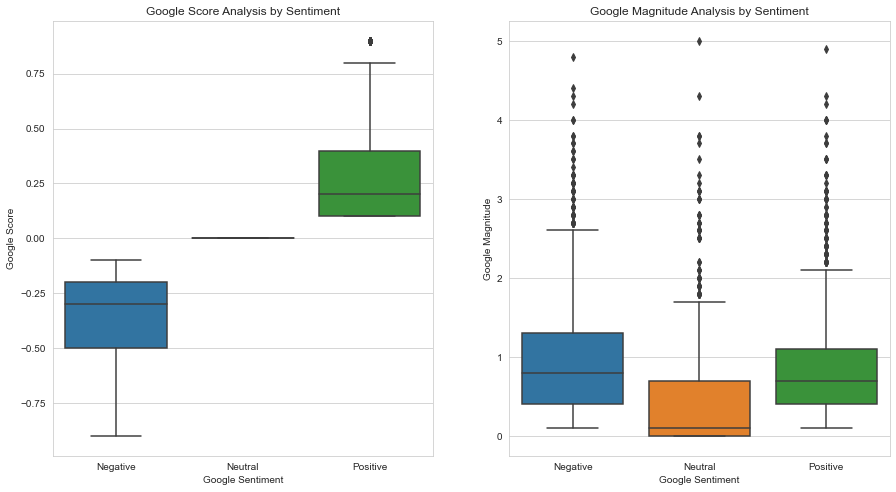

In [39]:
# make boxplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (15,8))

sns.boxplot(x= 'Google Sentiment', y= 'Google Score', 
            data= google_partial, ax= ax1)

sns.boxplot(x= 'Google Sentiment', y= 'Google Magnitude', 
            data= google_partial, ax= ax2)
ax1.set_title('Google Score Analysis by Sentiment')
ax2.set_title('Google Magnitude Analysis by Sentiment')
plt.show()

### Sentiment Analysis with TextBlob

In [4]:
sentiment_df = pd.read_csv('data/tweets_translated.csv')

In [ ]:
# functions to clean tweets, get subjectivity and polarity scores and sentiment
def cleanTweet(txt):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(amp)", 
                           " ", str(txt)).split())

def getTextSubjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

def getTextPolarity(txt):
    return TextBlob(txt).sentiment.polarity

# function to determine if Tweet was positive, negative, or neutral
def getTextAnalysis(p):
    if p < 0:
        return 'Negative'
    elif p == 0:
        return 'Neutral'
    else:
        return 'Positive'

_In TextBlob:_

**Subjectivity** - Subjective sentences generally refer to personal opinion, emotion 
    or judgment whereas objective refers to factual information. 
    Subjectivity is also a float which lies in the range of (0,1)
    
**Polarity** - a float which lies in the range of (-1,1) 
    where 1 means positive statement and -1 means a negative statement

In [ ]:
# apply functions to tweets
sentiment_df['tweets'] = sentiment_df['tweets'].apply(cleanTweet)
sentiment_df['TB Subjectivity'] = sentiment_df['tweets'].apply(getTextSubjectivity)
sentiment_df['TB Polarity'] = sentiment_df['tweets'].apply(getTextPolarity)
sentiment_df['TB Sentiment'] = sentiment_df['TB Polarity'].apply(getTextAnalysis)
sentiment_df

In [ ]:
# plot as bar graph
plt.figure(figsize= (10, 6))
sns.countplot(data= sentiment_df, x = 'TB Sentiment')
plt.title('Sentiment Analysis of Tweets about COVID-19 Vaccine', fontsize = 14)
plt.xlabel('Score')
plt.show()

In [ ]:
# plot polarity and subjectivity and sentiment of the Tweet
plt.figure(figsize= (10,8))
sns.scatterplot(x= 'TB Polarity', y= 'TB Subjectivity', data= sentiment_df, hue= 'TB Sentiment')
plt.title('Polarity and Subjectivity of COVID-19 Vaccine Tweets by Sentiment', 
          fontsize = 14, fontweight= 'bold')
plt.show()

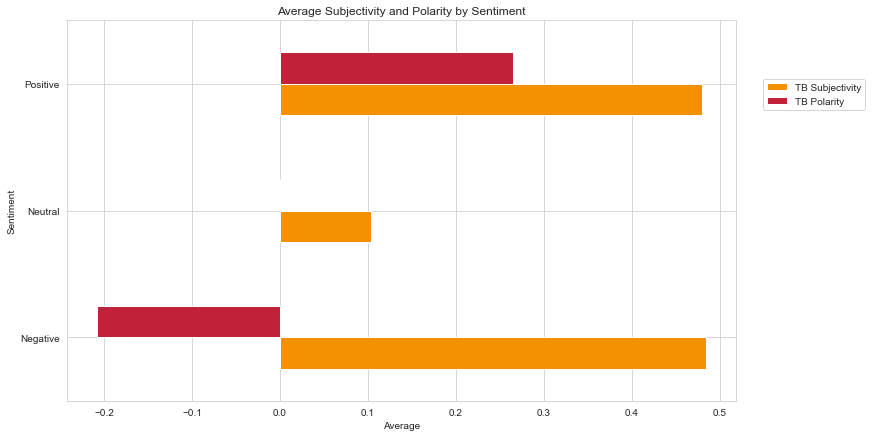

In [22]:
# plot averages
sentiment_df.groupby(['TB Sentiment']).mean().plot(kind= 'barh', 
                                                   figsize= (12,7), 
                                                   color= ['#f49103', '#c2213a'])

plt.title('Average Subjectivity and Polarity by Sentiment', fontsize = 12)
plt.ylabel('Sentiment')
plt.xlabel('Average')
plt.legend(loc= 'lower right', bbox_to_anchor= (1.2, .75))
plt.show()

Since the criteria for a neutral Tweet was a polarity = 0, neutral Tweets have no polarity

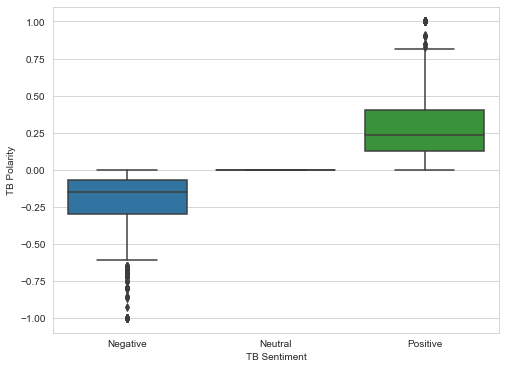

In [26]:
# other way to view above chart without subjectivity
plt.figure(figsize= (8, 6))
sns.boxplot(x= 'TB Sentiment', y= 'TB Polarity', data= sentiment_df)
plt.show()

In [ ]:
sentiment_df.groupby(['TB Sentiment']).mean()

* There are about 3 times more positive Tweets than negative ones
* Positive and negative Tweets have very similar Subjectivity scores (referring to opinions rather than facts)
* Positive Tweets have a higher polarity than negative Tweets (positive Tweets are more positive than negative Tweets are negative)

In [ ]:
# save all to csv
# sentiment_df.to_csv('data/tweets_sentiment_data.csv', index= False)

### Word Cloud, Word Freqency and Bigram

In [ ]:
# create word cloud
words = ' '.join([tweet for tweet in sentiment_df['tweets']])
wc = WordCloud(background_color= '#222222').generate(words)
plt.figure(figsize= (10, 6))
plt.imshow(wc.recolor(colormap= 'spring'))
plt.axis('off')
plt.title('COVID-19 Vaccine Word Cloud')
plt.show()

In [ ]:
# tokenizing
tokens = sentiment_df['tweets'].map(word_tokenize)
tokens

In [ ]:
# create stopwords list
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

In [ ]:
 # remove stop words make make all words lowercase
stopped_data = [w.lower() for l in tokens for w in l if w not in stopwords_list]
print(len(stopped_data))
stopped_data

In [ ]:
# show 20 most common words
words_freq = FreqDist(stopped_data)
freq_words_20 = words_freq.most_common(20)

In [ ]:
freq_words_20

In [ ]:
# separate elements to plot
x_val = [x[0] for x in freq_words_20]
y_val = [x[1] for x in freq_words_20]

# plot 20 most frequent words
plt.figure(figsize= (15, 10))
sns.barplot(y = x_val, x= y_val, palette= 'RdYlBu')

plt.title('20 Most Common Words')
plt.xlabel('Times Used')
plt.yticks(fontsize= 14)
plt.ylabel('Word')
plt.show()

In [ ]:
#bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()

tweets_finder = nltk.collocations.BigramCollocationFinder.from_words(stopped_data)

tweets_scored = tweets_finder.score_ngrams(bigram_measures.raw_freq)
tweets_scored[:10]

### Differences from Google and TextBlob

In [6]:
# sentiment_df = pd.read_csv('data/text_sentiment_TextBlob.csv')

In [9]:
temp_part = sentiment_df[:5546]
tb_part = temp_part[['TB Sentiment']]
tb_partial = tb_part.copy()

In [10]:
tb_partial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5546 entries, 0 to 5545
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   TB Sentiment  5546 non-null   object
dtypes: object(1)
memory usage: 43.5+ KB


In [11]:
google_partial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5546 entries, 0 to 5545
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              5546 non-null   object 
 1   tweets            5546 non-null   object 
 2   Google Score      5546 non-null   float64
 3   Google Magnitude  5546 non-null   float64
 4   Google Sentiment  5546 non-null   object 
dtypes: float64(2), object(3)
memory usage: 216.8+ KB


In [14]:
# join dfs together
together_df = pd.concat([google_partial, tb_partial], axis= 1, join= 'outer')
together_df.info()

In [15]:
together_df.plot(x = [])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5546 entries, 0 to 5545
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              5546 non-null   object 
 1   tweets            5546 non-null   object 
 2   Google Score      5546 non-null   float64
 3   Google Magnitude  5546 non-null   float64
 4   Google Sentiment  5546 non-null   object 
 5   TB Sentiment      5546 non-null   object 
dtypes: float64(2), object(4)
memory usage: 260.1+ KB


In [44]:
together_df

,time,tweets,Google Score,Google Magnitude,Google Sentiment,TB Sentiment
0,2021-04-01,"Concerning the use of aborted baby tissue in the J&amp;J Covid vaccine:\n\n“The J&amp;J vaccine has sparked debate among some religious communities because it was developed from stem cells obtained during two abortions decades ago.”\n\nEvil is still evil, even if it was decades ago.",-0.4,1.2,Negative,Negative
1,2021-04-01,imagine an animal getting the covid-19 vaccine b4 a human,0.0,0.0,Neutral,Neutral
2,2021-04-01,Definition of a microstate: https://t.co/8N0R8Mhl73\n\nSource of vaccine data: https://t.co/0RQFJPTrZZ,0.0,0.2,Neutral,Neutral
3,2021-04-01,"If I’ve Had COVID-19, Do I Still Need Two Doses of Vaccine? https://t.co/08AiBgfEHQ",0.0,0.5,Neutral,Neutral
4,2021-04-01,"My epidural was delayed again, somehow my covid vaccine does not interact well with an epidural. SOOOOO I should be getting it on my birthday. Yay. \n\n So far I have 1-2 dr appointments a week this entire month.\n \nOn the upside they've given me proper muscle relaxers this time.",0.1,3.1,Positive,Positive
...,...,...,...,...,...,...
5541,2021-04-02,"@Ladyjustice1312 @StephenBevan15 @mcfunny @fredwibblington @PierreKory @krebiozen @Kathmarval @BreezerGalway @crabb_vicki @KubeCatherine @GarySlegg @LauraSc72529359 @sim0n40 @dave_odo @agent_deadfool @BottomleyFiona @Theonew16516042 @CoralBlob @rossmarwood @jneill @silversynergy @Adelere @BaileInis @AdamBlayney @thewibblemovem1 @nickdalton1972 @_johnbye @UnjustSociety1 @MrsSarahMurray @CpnSindbad @k_b_lvi @KAS118 @gordonrlove @braidedmanga @1ohreally @timbofive @mancunianmedic @AsItIs13658173 @William25844148 @botvolution @detroutspinner1 @fiski70 @marmite @LucifersTweetz @bbcquestiontime @Covid19Critical @BIRDGroupUK I have had the Astra Zeneca vaccine and feel fine. I now have protection against Covid 19 and reduced ability to pass it on to anyone else. \n\nThe world has not gone insane, we are just trying to stop a virus that has killed at least 2.8M people so far. Covid is real.",0.2,2.3,Positive,Negative
5542,2021-04-02,"@simsy1977 Related topic - insurance companies say that if the EU insists on a vaccine certificate to travel to an EU state, they will have make it compulsory as a condition of obtaining travel insurance, at a higher price to cover the cost of Covid treatment.\nThey can’t wait to rip us off.",-0.6,1.2,Negative,Positive
5543,2021-04-02,How one state is tracing 'vaccine breakthrough' cases: fully vaccinated people who test positive for COVID-19 https://t.co/Pz9qlGJ4G5,0.0,0.0,Neutral,Positive
5544,2021-04-02,How one state is tracing 'vaccine breakthrough' cases: fully vaccinated people who test positive for COVID-19 https://t.co/k3GeG7dEzv,0.0,0.0,Neutral,Positive


For fun, let's see some Tweets that TextBlob and Google ranked differently.

In [95]:
different = together_df[together_df['TB Sentiment'] != together_df['Google Sentiment']]
different.head(10)

,time,tweets,Google Score,Google Magnitude,Google Sentiment,TB Sentiment
5,2021-04-01,Blake Lively hilariously called out her husband Ryan Reynolds for what he posted after they got their COVID-19 vaccine shots https://t.co/GixfzNnHBc,0.0,0.0,Neutral,Positive
6,2021-04-01,@Kit_Yates_Maths Tests\n1. Vax deployment ✅✅\n2. Vax reduces hospitalisation ✅✅\n3. Infection rates unsubstantiated pressure on NHS ✅\n4. Variants of concern ☑️\n\nSo not measured but very conservative \nhttps://t.co/iVMKF2pPsF https://t.co/ta4t21HH9s,0.0,1.7,Neutral,Positive
8,2021-04-01,"I received my second dose of the Covid-19 vaccine today. I’m grateful, and hopeful for a return to normalcy on the horizon. I want to thank everyone working so hard to get folks vaccinated. Get your vaccine here: https://t.co/YAl9dOBkLo #GetYourShot #vaccinated https://t.co/WH5AdwbgkP",0.4,1.7,Positive,Negative
9,2021-04-01,@JoshMatlow Ok how many times has this How do we have vaccine clinics in areas where Covid cases are highest ?\nOr most important paid sick leave?\nPlease Mr Matlow what we can we the ordinary citizen do? It seems you are unable to do anything? I am pleading with you do something!,-0.2,1.6,Negative,Positive
11,2021-04-01,@Pfizer @moderna_tx @FDA @J&amp;J @AstraZeneca when will the children ages 1-12 Covid vaccine trial be completed? 3 boys aged 5 to 9 waiting with rolled up sleeves. #GetTheShot #GetVaccinated #COVID19,0.0,0.5,Neutral,Negative
12,2021-04-01,Over 5M Canadians given at least one COVID-19 vaccine dose as rollout picks up steam https://t.co/zk9dQd3mRU,0.0,0.0,Neutral,Negative
13,2021-04-01,@Bobbyyo48025095 @mtgreenee Exercise is NOT a vaccine. I have students who are young and healthy but got Covid. They survived but now have ongoing lung problems. Everyone needs to vaccinate,-0.2,2.3,Negative,Positive
14,2021-04-01,"Spain’s Madrid region halts COVID-19 vaccinations at health centers for four days so medical staff can rest over the Easter holiday, despite pleas from the national government not to pause the fight against surging infections. https://t.co/m6bKky2u1C",0.1,0.5,Positive,Neutral
16,2021-04-01,@ZaidJilani Vermont has different formal eligibility rules based on whether you are a BIPOC household. \n\nhttps://t.co/eZbrFlIBsS,0.1,0.4,Positive,Neutral
17,2021-04-01,"COVID cases spiking in Massachusetts, more communities now at high-risk\n\n""... B.1.1.7 is widespread in Massachusetts and is circulating within communities...It is critical to do everything possible to keep variants of concern from becoming more widespread""\nhttps://t.co/4u2WNwhsjp",-0.2,0.6,Negative,Positive


In [94]:
# percent of tweets rated differently
len(different) / len(together_df)

0.5394879192210602

53% of Tweets were given different sentiments from Google and TextBlob

In [82]:
ggl_vals = together_df['Google Sentiment'].value_counts()
tb_vals = together_df['TB Sentiment'].value_counts()
print ('Google: \n{} \n\nTextBlob: \n{}'.format(ggl_vals, tb_vals))

Google: 
Negative    2068
Positive    1976
Neutral     1502
Name: Google Sentiment, dtype: int64 

TextBlob: 
Positive    2704
Neutral     1790
Negative    1052
Name: TB Sentiment, dtype: int64


Since values are in a different order, they will be re-ordered before plotted.

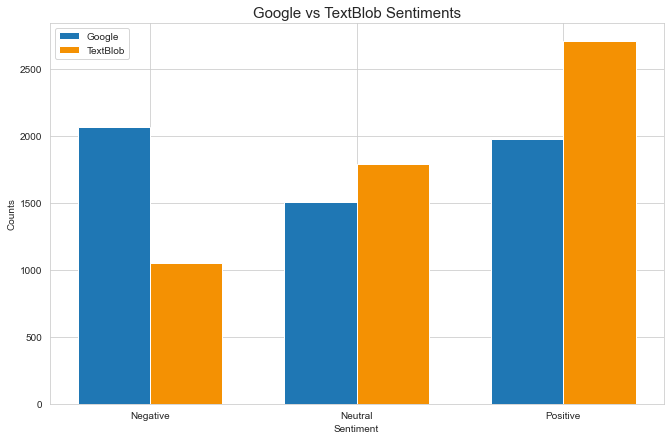

In [96]:
index = np.arange(3)
bar_width = 0.35

# get values in same order
g_vals = [ggl_vals[0], ggl_vals[2], ggl_vals[1]]
t_vals = [tb_vals[2], tb_vals[1], tb_vals[0]]

#plot
fig, ax = plt.subplots(figsize= (11,7))
google = ax.bar(index, g_vals, bar_width, label= 'Google')
textbb = ax.bar(index + bar_width, t_vals, bar_width, label= 'TextBlob', color='#f49103')

# set labels
ax.set_xlabel('Sentiment')
ax.set_ylabel('Counts')
ax.set_title('Google vs TextBlob Sentiments', fontsize = 15)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])

plt.legend()
plt.show()

We can see that Google's Natural Language Analysis and TextBlob's analysis yield different results.
* Google had almost twice as many negative Tweets as TextBlob
* TextBlob ranked 25% more Tweets as 'Positive'

In [110]:
# together_df.to_csv('data/google_tb_sentiments.csv', index= False)

## Classification Modeling
---
Time to vectorize and build some models!

In [99]:
data = pd.read_csv('data/text_sentiment_TextBlob.csv')

In [101]:
# create lists of only tweets or labels, convert tweets to unicode
X = data['tweets'].astype('U')
y = data['TB Sentiment']

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

In [103]:
# use TweetTokenizer and TF IDF Vectorizer
def tokenize(tweet):
    tknzr = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
    return tknzr.tokenize(tweet)

tfidf_vect = TfidfVectorizer(stop_words= 'english', tokenizer= tokenize)

In [104]:
tfidf_Xtrain = tfidf_vect.fit_transform(X_train)
tfidf_Xtest = tfidf_vect.transform(X_test)

In [105]:
print('Xtest shape:', tfidf_Xtest.shape)
print('Xtrain shape:', tfidf_Xtrain.shape)

Xtest shape: (3715, 19879)
Xtrain shape: (14860, 19879)


### Building Models

In [116]:
# import necessary libraries for modeling
from sklearn.metrics import f1_score, accuracy_score, classification_report,\
confusion_matrix, roc_auc_score, plot_confusion_matrix, plot_roc_curve

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [107]:
# instantiate classifiers for vanilla models
classifiers = {
    'Logistic Regression' : LogisticRegression(max_iter=200), 
    'Random Forest' : RandomForestClassifier(), 
    'Support Vector Machine' : SVC(), 
    'XGBoost' : XGBClassifier(), 
    'Naive Bayes' : MultinomialNB()
}

In [111]:
# create DataFrame to hold results from vanilla models
# takes approx 2 mins to run
results = pd.DataFrame(columns= ['Train_accuracy', 'Test_accuracy', 
                                 'Weighted_F1_score'])

# predict, get accuracy and f1 scores and add to dataframe
conf_matrices = []
for key, value in classifiers.items():
    # fit models
    value.fit(tfidf_Xtrain, y_train)
    train_pred = value.predict(tfidf_Xtrain)
    y_pred = value.predict(tfidf_Xtest)
    
    # get accuracy, f1 score
    train_acc = accuracy_score(y_train, train_pred) * 100
    test_acc = accuracy_score(y_test, y_pred) * 100
    weight_f1 = f1_score(y_test, y_pred, average= 'weighted')
    
    # get false neg and true positive
    # add to confusion matrices list to view later if desired
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices.append(cm)
    
    # add measurements to datafram
    results.loc[key] = [round(train_acc, 2), round(test_acc, 2), 
                        round(weight_f1, 2)]

In [112]:
results.sort_values(by= ['Test_accuracy', 'Weighted_F1_score'], ascending= False)

,Train_accuracy,Test_accuracy,Weighted_F1_score
Logistic Regression,90.49,77.95,0.77
XGBoost,85.28,77.39,0.77
Support Vector Machine,98.45,77.28,0.76
Random Forest,99.90,75.40,0.74
Naive Bayes,71.06,61.75,0.55


Naive Bayes performed the worst while XGBoost performed the best with the least amount of overfitting. 

Next, let's tune some hyperparameters and see if we can get better results.

#### Hyperparameter Tuning

In [113]:
# function to get results after each model

def get_results(model, model_name):
    train_pred = model.predict(tfidf_Xtrain)
    y_pred = model.predict(tfidf_Xtest)
    
    # get classification report
    print('{} Classification Report'.format(model_name))
    print(classification_report(y_test, y_pred))
    
    # get confusion matrix
    plot_confusion_matrix(model, tfidf_Xtest, y_test, cmap= "Blues", 
                          values_format= '.5g')
    plt.grid(False)
    plt.title('{} Confusion Matrix'.format(model_name))
    plt.show()
    
    # get accuracy and F1 scores
    train_acc = accuracy_score(y_train, train_pred) * 100
    test_acc = accuracy_score(y_test, y_pred) * 100
    macro_f1 = f1_score(y_test, y_pred, average= 'macro')
    weight_f1 = f1_score(y_test, y_pred, average= 'weighted')
    
    #get false neg and true positive
    cm = confusion_matrix(y_test, y_pred)
    
    # save measurements into results df
    results.loc[model_name] = [round(train_acc, 2), round(test_acc, 2), 
                               round(macro_f1, 2), round(weight_f1, 2)]

**XGBoost**

In [114]:
# set up hyperparameter grid
param_grid_xgb = {
    'learning_rate' : [0.05, 0.08, 0.1, 0.2],
    'max_depth' : [3, 4, 6, 8], 
    'min_child_weight' : [1, 2, 3]
}

In [ ]:
# instantiate classifer, fit on model through randomized search
xgb = XGBClassifier(objective= 'softmax')
RS_xgb = RandomizedSearchCV(xgb, param_grid_xgb, scoring= 'f1_weighted', random_state= 27)
RS_xgb.fit(tfidf_Xtrain, y_train)

In [ ]:
RS_xgb.fit(tfidf_Xtrain, y_train)

In [ ]:
RS_xgb.best_params_

In [ ]:
get_results(RS_xgb, 'RS XGBoost')

In [ ]:
# original confusion matrix that was not tuned
conf_matrices[3]

**Random Forest**

In [ ]:
param_grid_rf = {
    'n_estimators' : [100, 150], 
    'max_depth' : [100, 120], 
    'min_samples_split' : [2, 4, 8], 
    'min_samples_leaf' : [3, 5]
}

In [ ]:
rf = RandomForestClassifier()
RS_rf = RandomizedSearchCV(rf, param_grid_rf, n_iter= 20, scoring= 'f1_weighted', 
                          random_state= 27)
RS_rf.fit(tfidf_Xtrain, y_train)

In [ ]:
RS_rf.best_params_

In [ ]:
get_results(RS_rf, 'RS Random Forest')

**Support Vector Machines**

In [ ]:
param_grid_svc = {
    'kernel': ['rbf'], 
    'gamma': ['scale', 1e-3, 1e-4, 1e-5],
    'C': [1, 10, 100]
}

In [ ]:
svc = SVC()
RS_svc = RandomizedSearchCV(svc, param_grid_svc, scoring= 'f1_weighted')
RS_svc.fit(tfidf_Xtrain, y_train)

In [ ]:
RS_svc.best_params_

In [ ]:
get_results(RS_svc, 'RS Support VM')

**Logistic Regression**

In [ ]:
param_grid_lg = {
    'penalty' : ['l1', 'l2'], 
    'C': [0.05, 0.1, 1], 
    'class_weight' : [None, 'balanced']
    'random_state' : [27]
}

In [ ]:
lg = LogisticRegression()
GS_lg = GridSearchCV(lg, param_grid_lg, scoring= 'f1_weighted')
GS_lg.fit(tfidf_Xtrain, y_train)

In [ ]:
GS_lg.best_params_

In [ ]:
get_results(GS_lg, 'GS Logistic Regression')

## Results

In [ ]:
results = results.sort_values(by= ['Test_accuracy', 'Weighted_F1_score'], ascending= False)
results

### Plots

In [ ]:
# plot test accuracy
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x= results['Test_accuracy'], y= results.index, palette = 'twilight')
plt.vlines(x= 79.03, ymin = -.5, ymax= 8.25, linestyles= 'dashed', color = 'r', label= 'Test Accuracy 79.03')
plt.title('Test Accuracy of all Models', fontsize= 15)
plt.ylabel('Model')
plt.xlabel('Accuracy in %')
plt.xlim(55, 82)
ax.legend(loc = 'lower right')
plt.show()

In [ ]:
# plot weighted f1 score
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x= results['Weighted_F1_score'], y= results.index, 
            palette = 'twilight')
plt.title('Weighted F1 Score of all Models', fontsize= 15)
plt.ylabel('Model')
plt.xlabel('Weighted F1 Score')
plt.xlim(0.45, 0.83)
plt.show()

### Feature Extraction 